# Building LLMs from the Ground Up: A 3-hour Coding Workshop
- Sebastian Raschka

https://www.youtube.com/watch?v=quh7z1q7-uc

In [ ]:
!pip install -r https://raw.githubusercontent.com/rasbt/LLM-workshop-2024/refs/heads/main/requirements.txt

**NOTE:** using pytorch at the end for dataloading & the tiktoken library, otherwise everything will be from scratch

In [ ]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

In [ ]:
# !git clone https://github.com/rasbt/LLM-workshop-2024

In [ ]:
# import os
# print(os.getcwd())

here we load the verdict (short story dataset)

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

here we use a RegEx to split on whitespaces & punctuation to tokenize our dataset
- we then print the first 38 tokens

In [ ]:
import re

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
# preprocessed = [item for item in preprocessed if item]
print(preprocessed[:38])

In [ ]:
print("Number of tokens:", len(preprocessed))

length of unique tokens:
- Note: `set()` removes any duplicates

In [ ]:
len(set(preprocessed))

In [ ]:
sorted(set(preprocessed))

A token ID is then assigned to each unique token:

In [ ]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

In [ ]:
# for i in enumerate(all_words):
#     print(i)

In [ ]:
vocab = {token:integer for integer,token in enumerate(all_words)}

first 50 entries in this vocabulary:

In [ ]:
# vocab.items()

In [ ]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

Let's now put it all together into a tokenizer class:
- The `encode` function turns text into token IDs
- The `decode` function turns token IDs back into text

In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

We can use the tokenizer to encode (that is, tokenize) texts into integers:
- These integers can then be embedded (later) as input of/for the LLM

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

We can decode the integers back into text:

In [ ]:
tokenizer.decode(ids)

In [ ]:
tokenizer.decode(tokenizer.encode(text))

## 2.3 BytePair encoding
- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- here we use the BPE tokenizer from OpenAI's open-source tiktoken library

In [ ]:
# pip install tiktoken

In [ ]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

In [ ]:
strings = tokenizer.decode(integers)

print(strings)

BPE tokenizers break down unknown words into subwords and individual characters:

In [ ]:
tokenizer.encode("Akwirw ier", allowed_special={"<|endoftext|>"})

## 2.4 Data sampling with a sliding window
- how we create the data loading for LLMs
- LLMs are trained to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict
- For this, we use a sliding window approach, changing the position by +1:

In [ ]:
from supplementary import create_dataloader_v1


dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

here we see the inputs in the tensor above, then below we have the targets which are the same as the inputs shifted by 1 position.
- batch size=8

# 3) Coding an LLM architecture

## 3.1 Coding an LLM architecture
- Models like GPT, Gemma, Phi, Mistral, Llama etc. generate words sequentially and are based on the decoder part of the original transformer architecture
- Therefore, these LLMs are often referred to as "decoder-like" LLMs
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code

- In this notebook, we consider embedding and model sizes akin to a small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s Language Models are Unsupervised Multitask Learners (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)

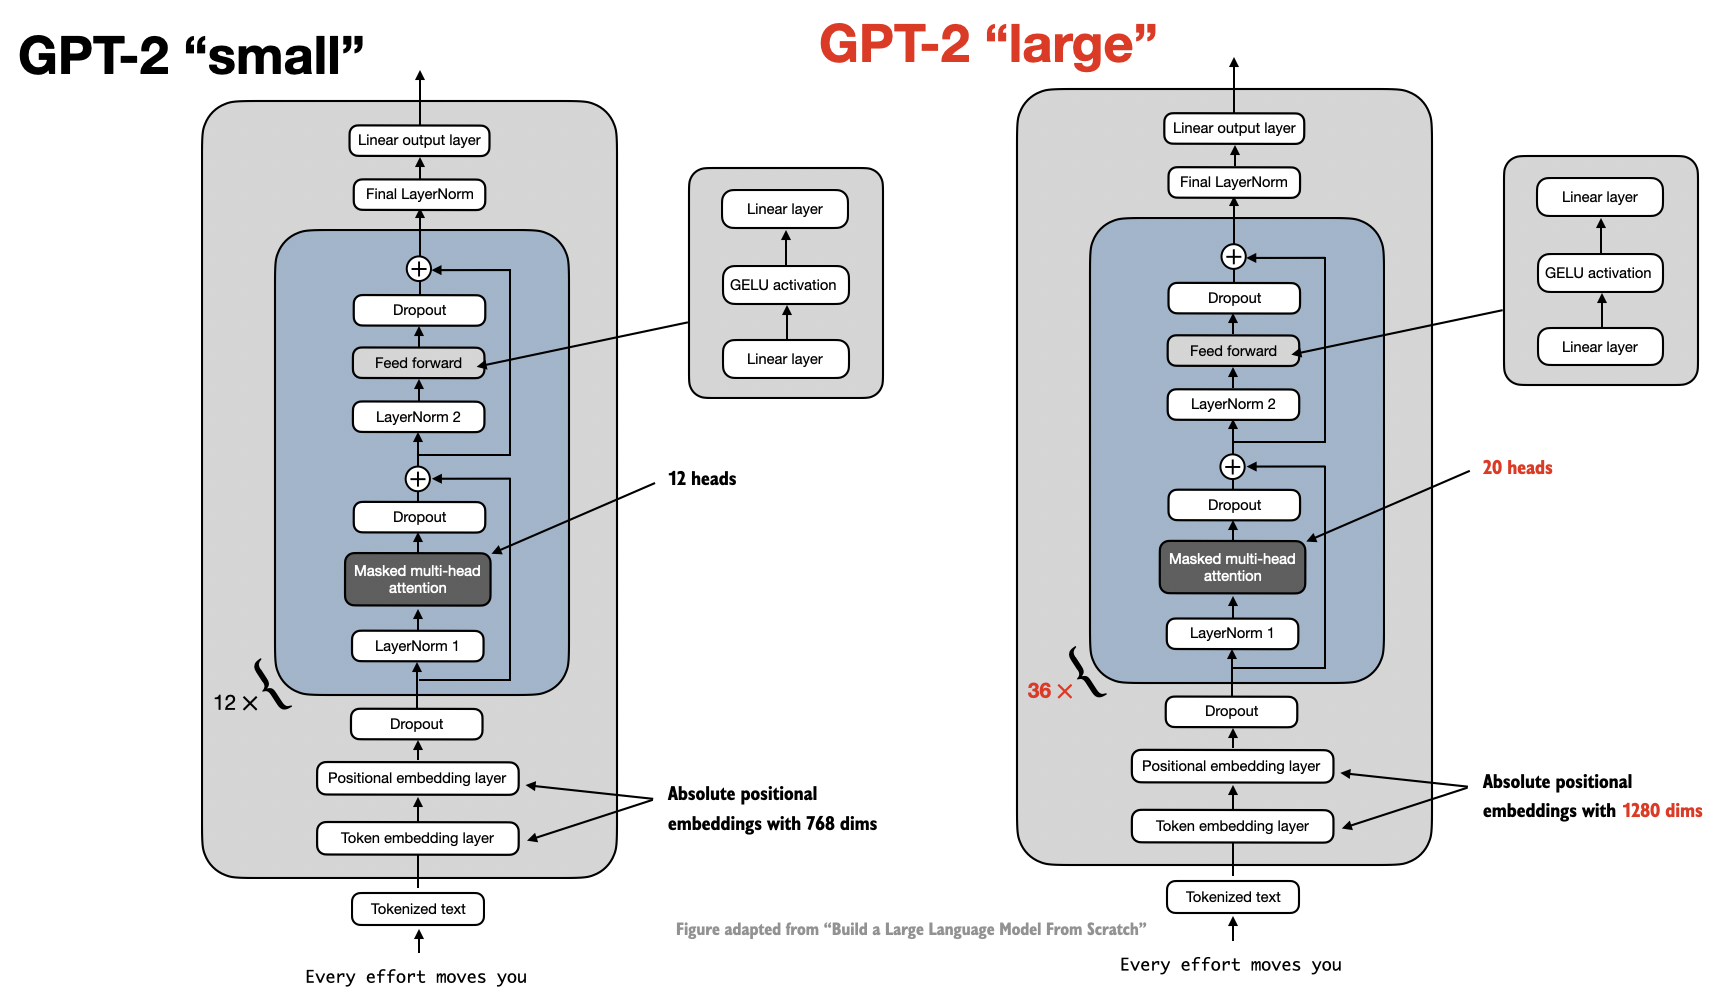

NOTE: the only differences
- number of times the transformer block is repeated (12 vs 36)
- 20 heads instead of 12 heads in the Masked multi-head attention module
    - heads are analogous to channels in ConvNets
- 1280 vs 768 dim positional embeddings
    - each token ID is represted by a 768 dim vector (or 1280)
    - the embedding size is larger in the large model - each vector representing 1 token is larger

Models like Llama and others are very similar to this model, since they are all based on the same core concepts

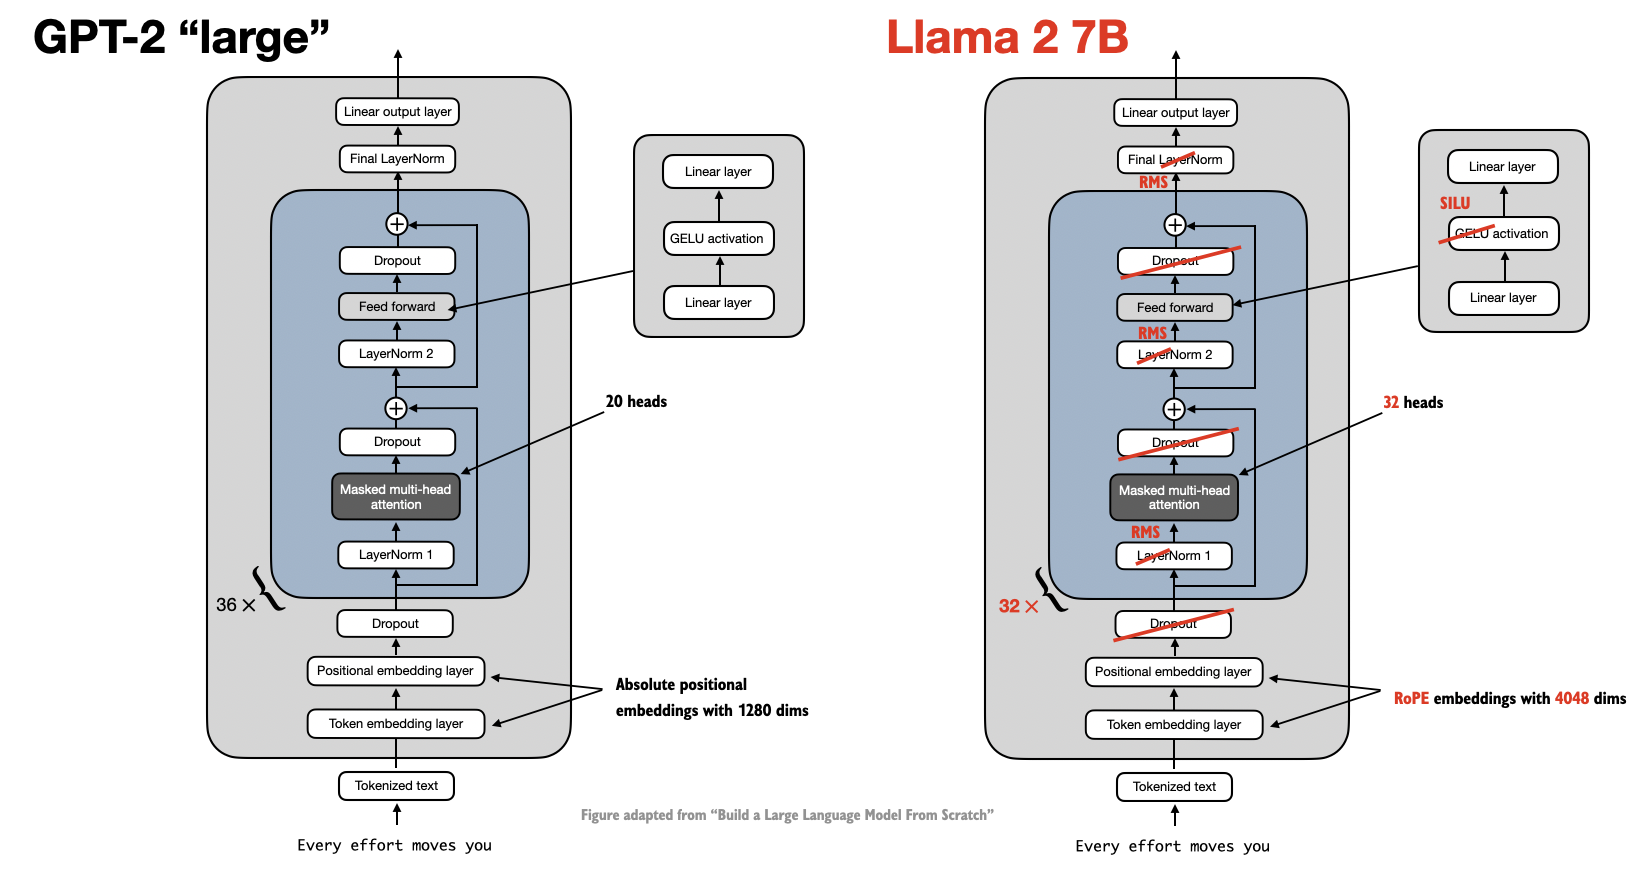

NOTE: dropout is not very popular in LLMs anymore so most architectures don't use it anymore

**Changes:**
- Dropout was removed in Llama 
- LayerNorm swapped with RMS
- GELU swapped with SiLU
- Rotary Positional Embedding (RoPE) used
    - different form of embedding the words

Configuration details for the 124 million parameter GPT-2 model (GPT-2 "small") include:

hyperparameter configration to get GPT-small model:
- context_length: how many tokens you can provide as input
    - newer LLMs support more tokens but this also makes it more memory intensive
- n_layers: num of times the transformer block gets repeated
- vocab_size: how many unique words in the vocabulary
    - in our case corresponds to the BPE tokenizer loaded earlier

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## 3.2 Coding the GPT model


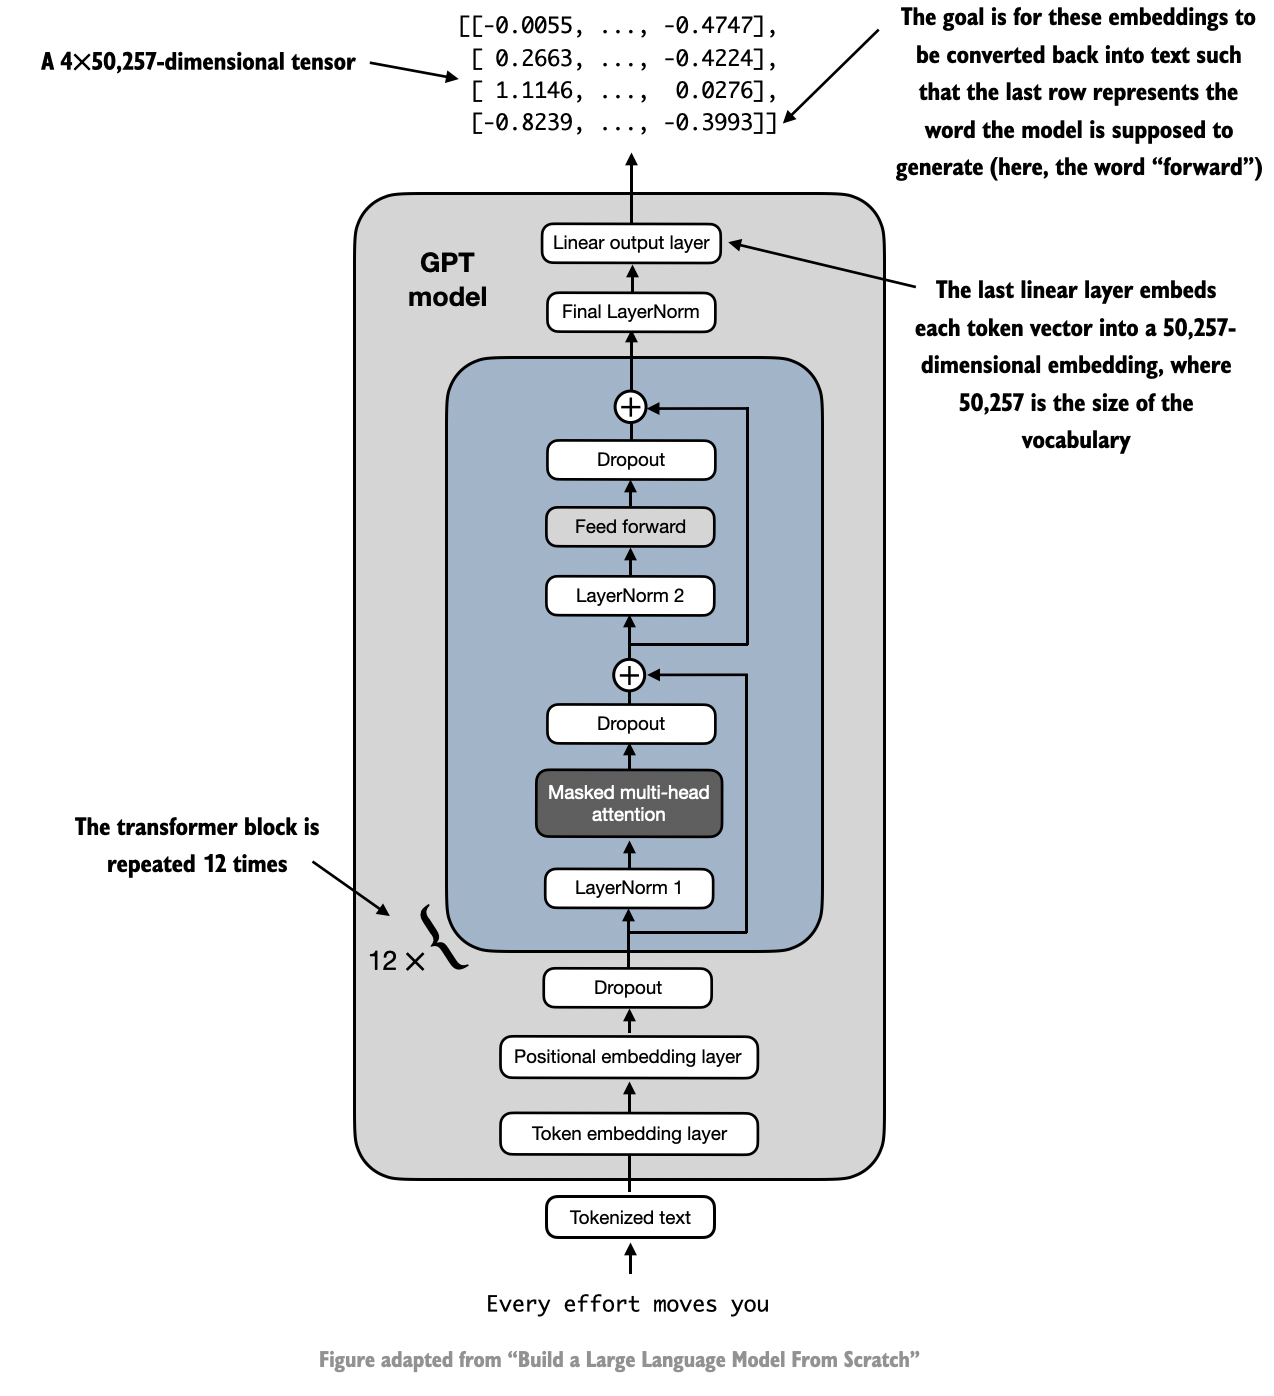

we have 4 words (4 tokens in this case) so we have rows in the output, each of which has 50,257 columns
- the cols here correspond to the vocab
    - we are looking for the highest value in the row - which corresponds to a token ID



Below we initialize the GPT model:
- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [ ]:
import torch.nn as nn
from supplementary2 import TransformerBlock, LayerNorm


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:


In [ ]:
import torch
# import tiktoken

# tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

**Output shape: torch.Size(`[2, 4, 50257]`)**
- we have `2` input examples
- each input example has `4` tokens
- each of these tokens is now represented by a `50257` dim vector


## 3.4 Generating text
LLMs like the GPT model we implemented above are used to generate one word at a time
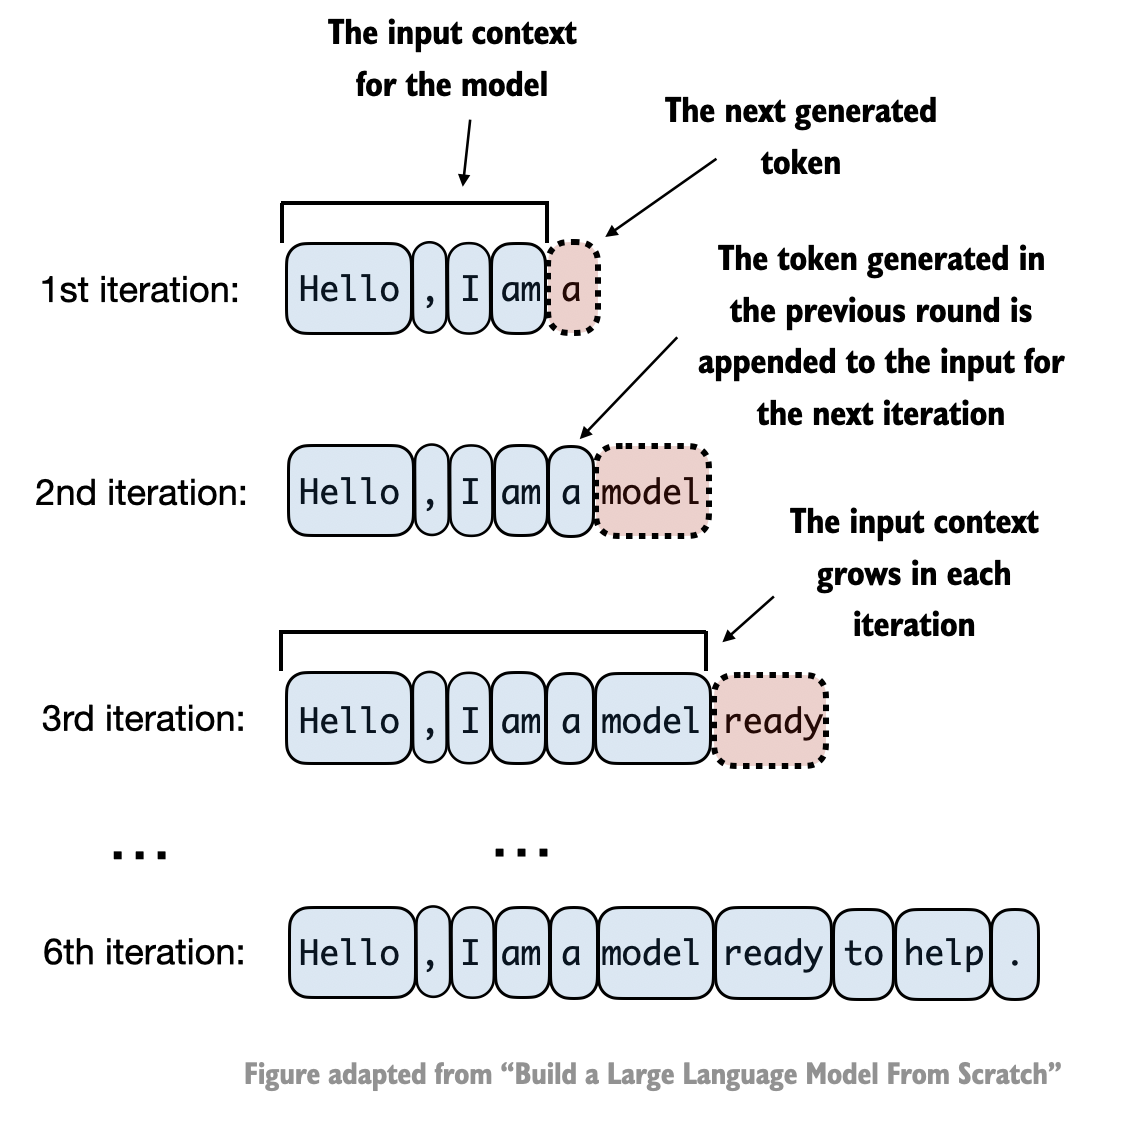

The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- The figure below depicts how the GPT model, given an input context, generates the next word token

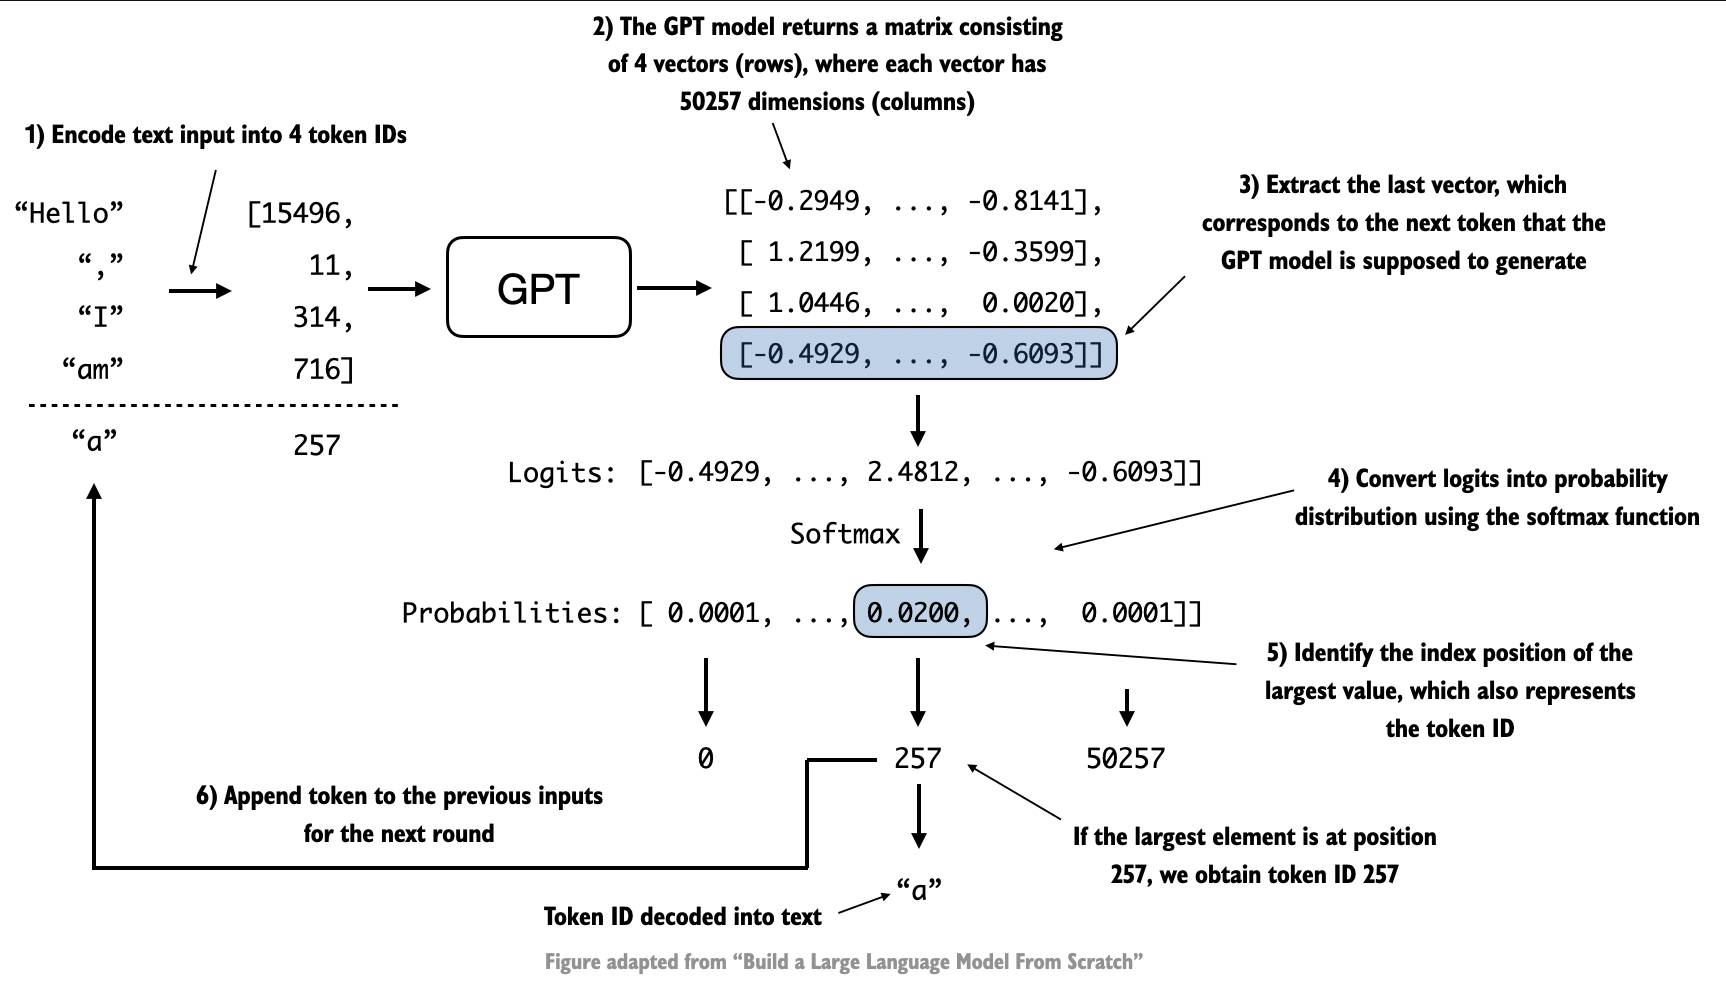

NOTE: you can think of logits as unnormalized scores. They are the raw output values produced by a model before any normalization or transformation into probabilities
- During training we normalize them to obtain probalities. These sum up to 1

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- The `generate_text_simple` above implements an iterative process, where it creates one token at a time

## Exercise: Generate some text
- Use the `tokenizer.encode` method to prepare some input text
- Then, convert this text into a pytorch tensor via (`torch.tensor`)
- Add a batch dimension via `.unsqueeze(0)`
- Use the `generate_text_simple` function to have the GPT generate some text based on your prepared input text
- The output from step 4 will be token IDs, convert them back into text via the `tokenizer.decode` method

In [ ]:
model.eval();  # disable dropout

## Solution:

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

In [ ]:
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Remove batch dimension and convert back into text:

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

- **Note:** the model is untrained; hence the random output texts above

# 4) Pretraining LLMs

In [ ]:
# from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

In this notebook, we implement the training loop and code for basic model evaluation to pretrain an LLM
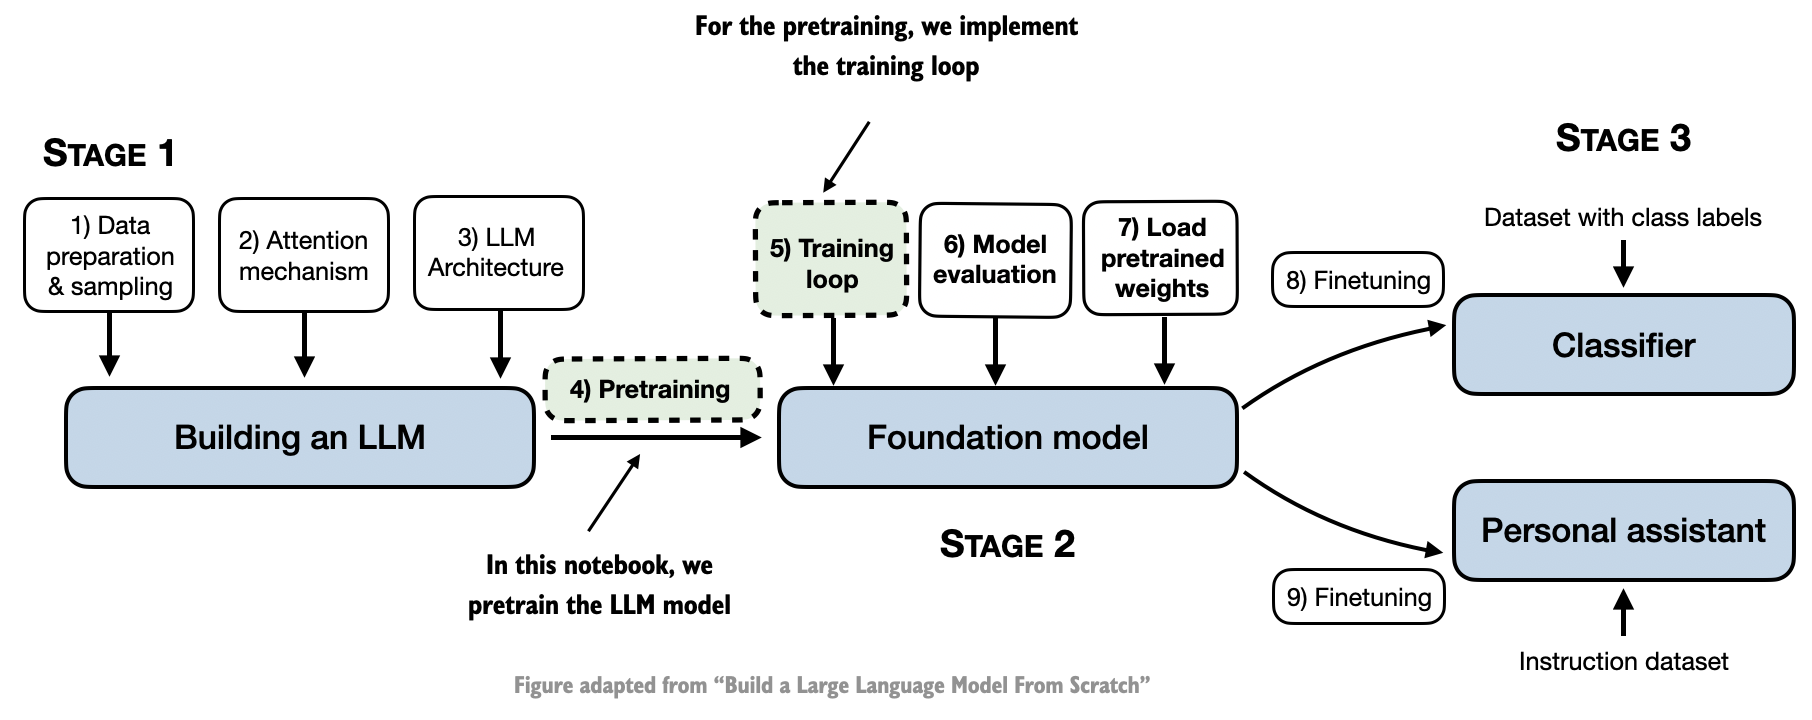

- We initialize a GPT model using the code from the previous notebook

In [ ]:
# import torch
from supplementary3 import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- Modern LLMs also don't use bias vectors in the nn.Linear layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting "qkv_bias": False
- We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens


- Next, we use the `generate_text_simple` function from the previous chapter to generate text
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

In [ ]:
# import tiktoken
from supplementary3 import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

## 4.2 Preparing the dataset loaders

- We use a relatively small dataset for training the LLM (in fact, only one short story)
    - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens
- Below, we use the same dataset we used in the data preparation notebook earlier

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 100 words

In [ ]:
# First 100 characters
print(text_data[:99])

In [ ]:
# Last 100 characters
print(text_data[-99:])

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

In [ ]:
from supplementary3 import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with
- Llama 2 7B was trained with a batch size of 1024, for example


- An optional check that the data was loaded correctly:

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

- Another optional check that the token sizes are in the expected ballpark:

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

- Next, let's calculate the initial loss before we start training


- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the device setting, we ensure that the data is loaded onto the same device as the LLM model

In [ ]:
from supplementary3 import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

## 4.2 Training an LLM
- In this section, we finally implement the code for training the LLM
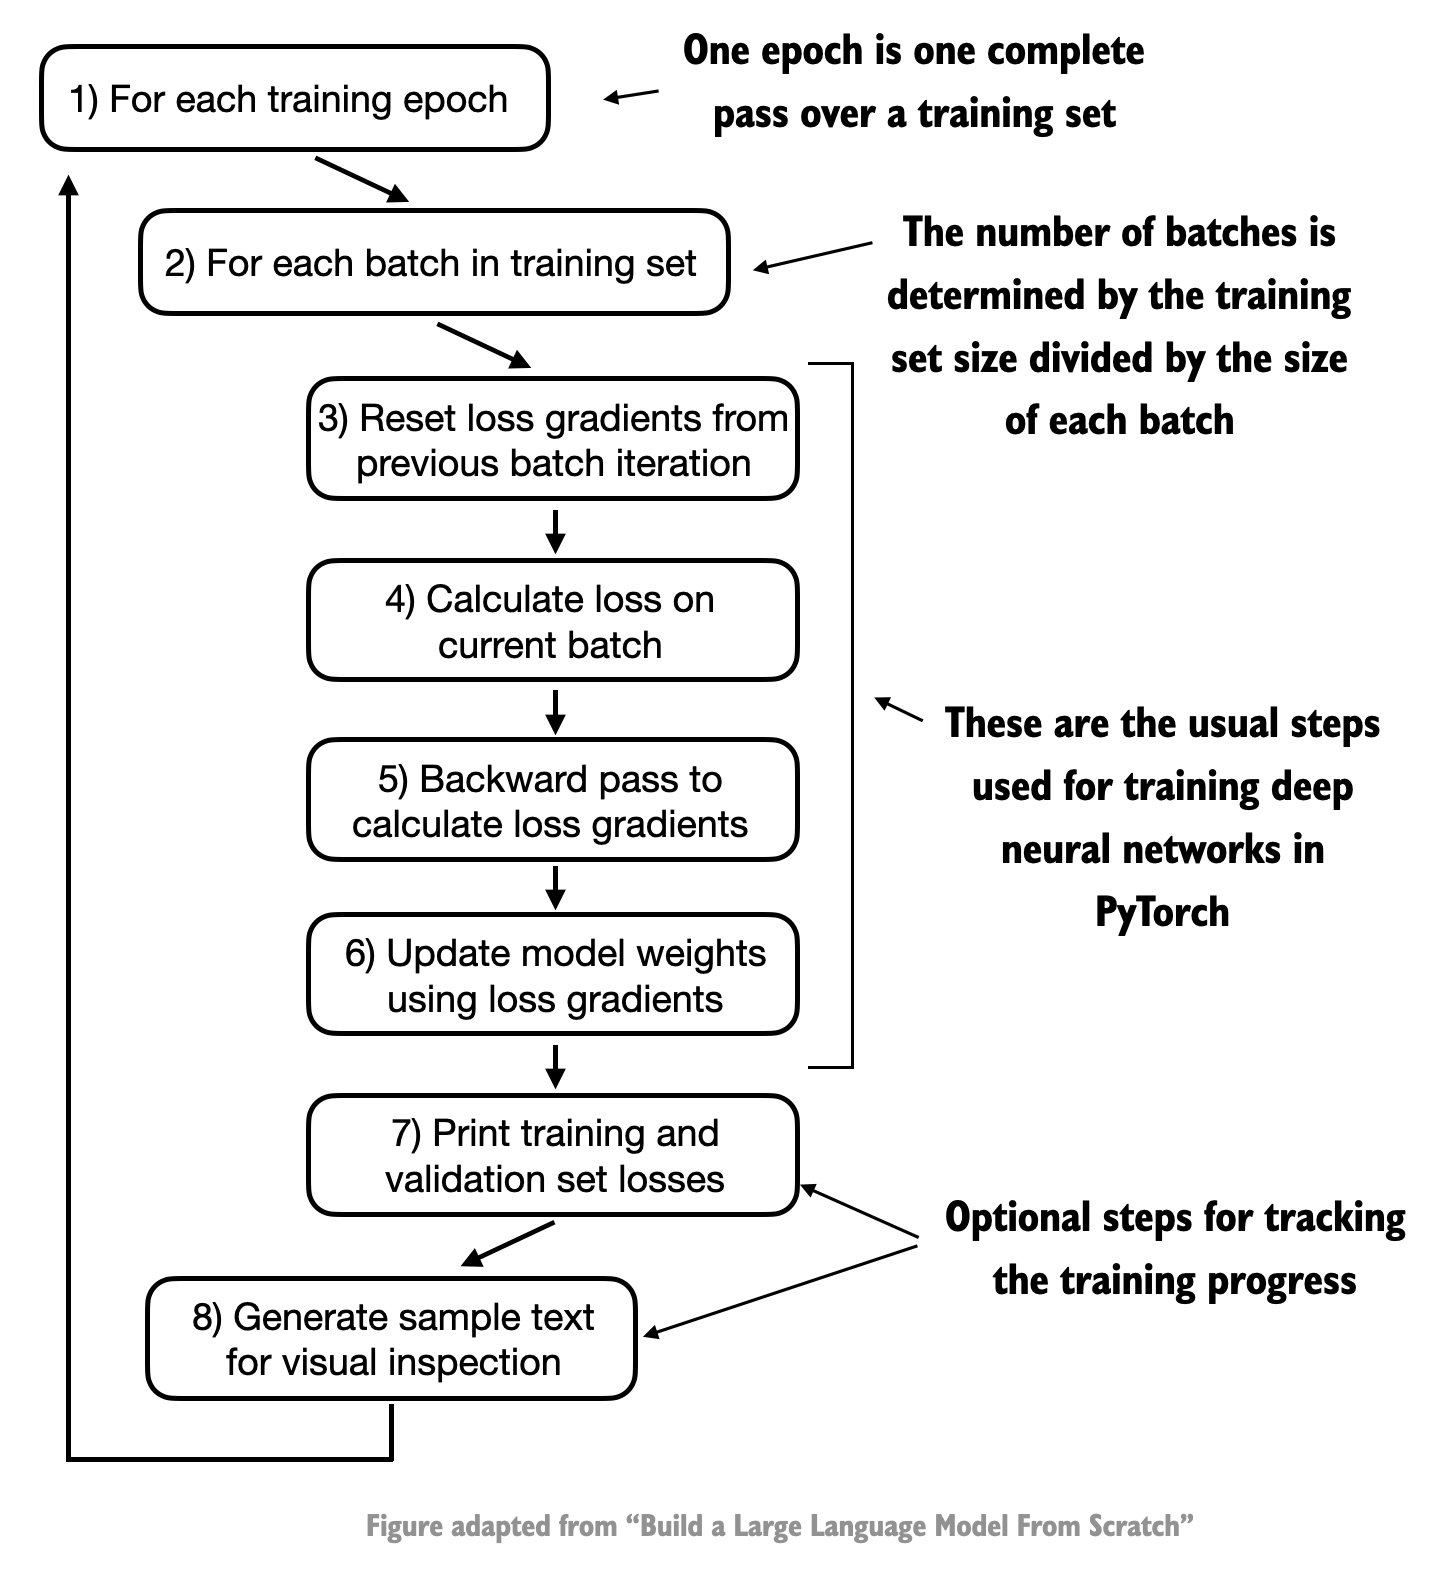

In [ ]:
from supplementary3 import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- Now, let's train the LLM using the training function defined above:


Note: usually only train LLMs for 1 epoch (1 iteration over the dataset) but because we're working with such a small dataset, here we're using 10 epochs to show some progress
- if your dataset is larger -> can probably reduce `num_epochs`

The model is overfitting. The train loss is much smaller than Val loss. (due to very small dataset)

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
from supplementary3 import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts overfitting
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
- There are decoding strategies (not covered in this workshop) that can mitigate this memorization by a certain degree
- Also note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times

## Exercise 1: Generate text from the pretrained LLM
Use the model to generate new text (HINT: scroll up to see how we generated text before)

In [ ]:
start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

## Exercise 2: Load the pretrained model in a new session
Open a new Python session or Jupyter notebook and load the model there
- Done. See: `exercise_2.ipynb`

# 5) Loading pretrained weights (part 1)


In [ ]:
# from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow",
        "tqdm"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

- Previously, we only trained a small GPT-2 model using a very small short-story book for educational purposes
- Fortunately, we don't have to spend tens to hundreds of thousands of dollars to pretrain the model on a large pretraining corpus but can load pretrained weights (we start with the GPT-2 weights provided by OpenAI)


- Since OpenAI used TensorFlow, we will have to install and use TensorFlow for loading the weights; tqdm is a progress bar library

The code will still use pyTorch, tensorflow is just required here for loading the weights from the original files that're provided by openai

In [ ]:
# pip install tensorflow tqdm

`download_and_load_gpt2` downloads the relevant files from the openai website
- contains a bunch of files that we will use to load the model
- loading the params & settings

In [ ]:
# Relative import from the gpt_download.py contained in this folder
from gpt_download import download_and_load_gpt2

- We can then download the model weights for the 124 million parameter model as follows:


In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

`settings` contain info about the architecture:
- `n_ctx` = context_length

In [ ]:
print("Settings:", settings)

the `params` contain the contents of the weights:
- this is a dict that contains the tranformer blocks
- `b` & `g` - vars for Final layer norm
- `wpe` - Positional embedding layer
- `wte` - Token embedding layer

In [ ]:
print("Parameter dictionary keys:", params.keys())

In [ ]:
print(params["blocks"][0].keys())

- attention
- 2x layer norms
- mlp = Feed Fordward - consists of 2 Fully connected layers (linear -> act -> linear)

In [ ]:
print(params["blocks"][0]["mlp"]["c_fc"].keys())

this has both a bias & weight matrix

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

- Alternatively, "355M", "774M", and "1558M" are also supported model_size arguments
- The difference between these differently sized models is summarized in the figure below:

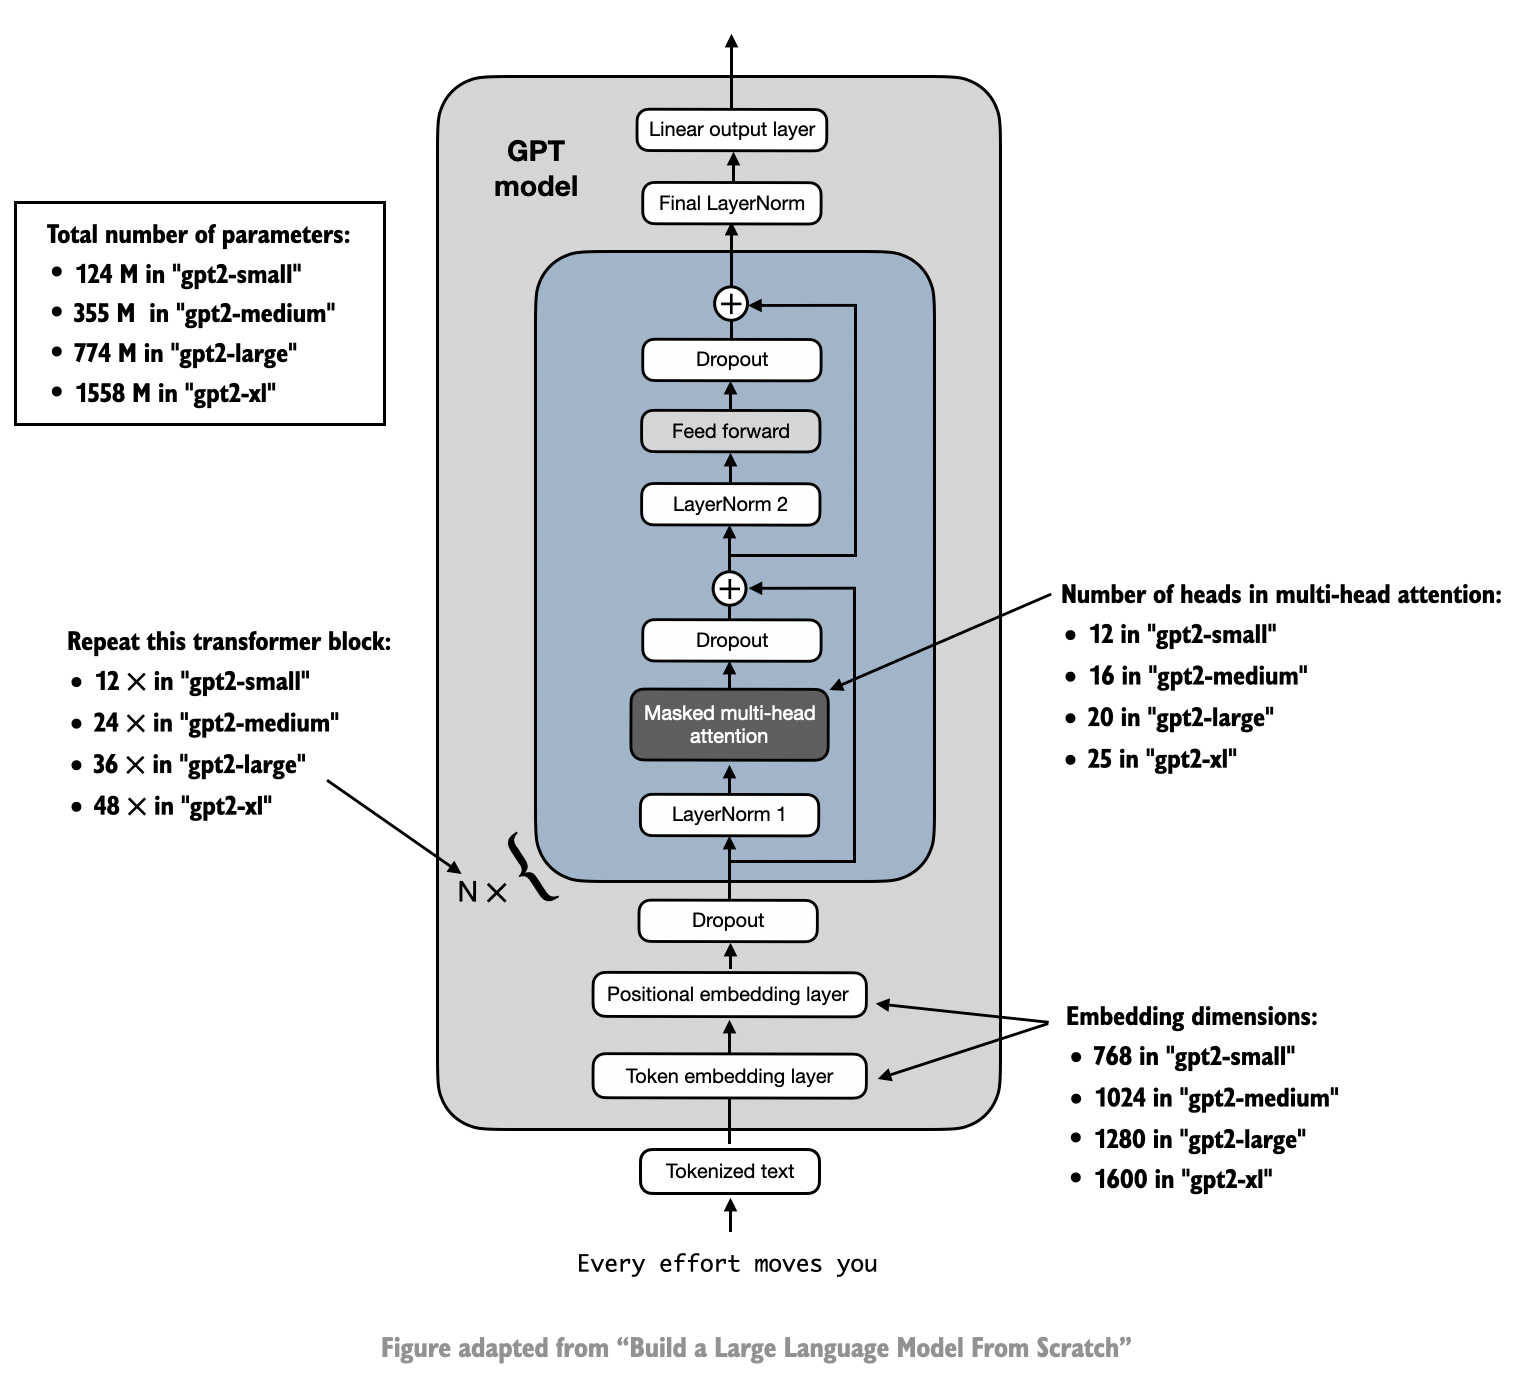

- Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance
- First, we initialize a new GPTModel instance
- Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too
- We are also using the 1024 token context length that was used by the original GPT-2 model(s)

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

- the code above allows you to swap between models by updating the `model_name` param 
- had to increase the `context_length` to `1024` because the original model was trained with that context size
    - this is to make the positional embeddings match
- `qkv_bias` is no longer recommended but was used to train the original model, therefore we have to set it to `True` to match; so that we can load the weights correctly

initializing this model:

In [ ]:
from supplementary4 import GPTModel

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- The next task is to assign the OpenAI weights to the corresponding weight tensors in our `GPTModel` instance
    - makes sure the shapes of the left & right tensors match
    - converts the tensor into a torch parameter

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

utility function that loads the tensorflow weights into pytorch tensors which are then used by our model
- brute force - iterates over the transformer blocks
    - overrides our own weights (randomly init params) with the openai weights for every single weight

In [ ]:
import torch
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);

- If the model is loaded correctly, we can use it to generate new text using our previous generate function:

In [ ]:
# import tiktoken
from supplementary4 import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)

token_ids = generate_text_simple(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

- We know that we loaded the model weights correctly because the model can generate coherent text; if we made even a small mistake, the mode would not be able to do that

get repetition in our output text as it's still a small model - using the large & xl models will give much better results

# 5) Loading pretrained weights (part 2; using LitGPT)
- Now, we are loading the weights using an open-source library called LitGPT
- LitGPT is fundamentally similar to the LLM code we implemented previously, but it is much more sophisticated and supports more than 20 different LLMs (Mistral, Gemma, Llama, Phi, and more)
- 20+ high-performance LLMs with recipes to pretrain, finetune, deploy at scale.

### Basic usage:
    # ligpt [action] [model]
    litgpt  download  meta-llama/Meta-Llama-3-8B-Instruct
    litgpt  chat      meta-llama/Meta-Llama-3-8B-Instruct
    litgpt  evaluate  meta-llama/Meta-Llama-3-8B-Instruct
    litgpt  finetune  meta-llama/Meta-Llama-3-8B-Instruct
    litgpt  pretrain  meta-llama/Meta-Llama-3-8B-Instruct
    litgpt  serve     meta-llama/Meta-Llama-3-8B-Instruct

In [ ]:
# !pip install litgpt

In [ ]:
from importlib.metadata import version

pkgs = ["litgpt", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

- First, let's see what LLMs are supported

In [ ]:
!litgpt download list

- We can then download an LLM via the following command

In [ ]:
# !litgpt download microsoft/phi-2

- And there's also a Python API to use the model

here we import the `LLM` class from `litgpt`, then load the model that was just downloaded

In [ ]:
# from litgpt import LLM

# llm = LLM.load("microsoft/phi-2")

# llm.generate("What do Llamas eat?")

we can also stream the response - instead of generating the output all at once it will do it one token at a time

In [ ]:
# result = llm.generate("What do Llamas eat?", stream=True, max_new_tokens=200)
# for e in result:
#     print(e, end="", flush=True)

# 6) Instruction finetuning (part 1; intro)
## 6.1 Introduction to instruction finetuning
- We saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this last part of the workshop, we teach the LLM to follow instructions better

## 6.2 Preparing a dataset for supervised instruction finetuning
- We will work with a simple instruction dataset I prepared for this

In [ ]:
import json


file_path = "LLM-workshop-2024/06_finetuning/instruction-data.json"

with open(file_path, "r") as file:
    data = json.load(file)
print("Number of entries:", len(data))

Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [ ]:
print("Example entry:\n", data[50])

Note that the `'input'` field can be empty:


In [ ]:
print("Another example entry:\n", data[999])

- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

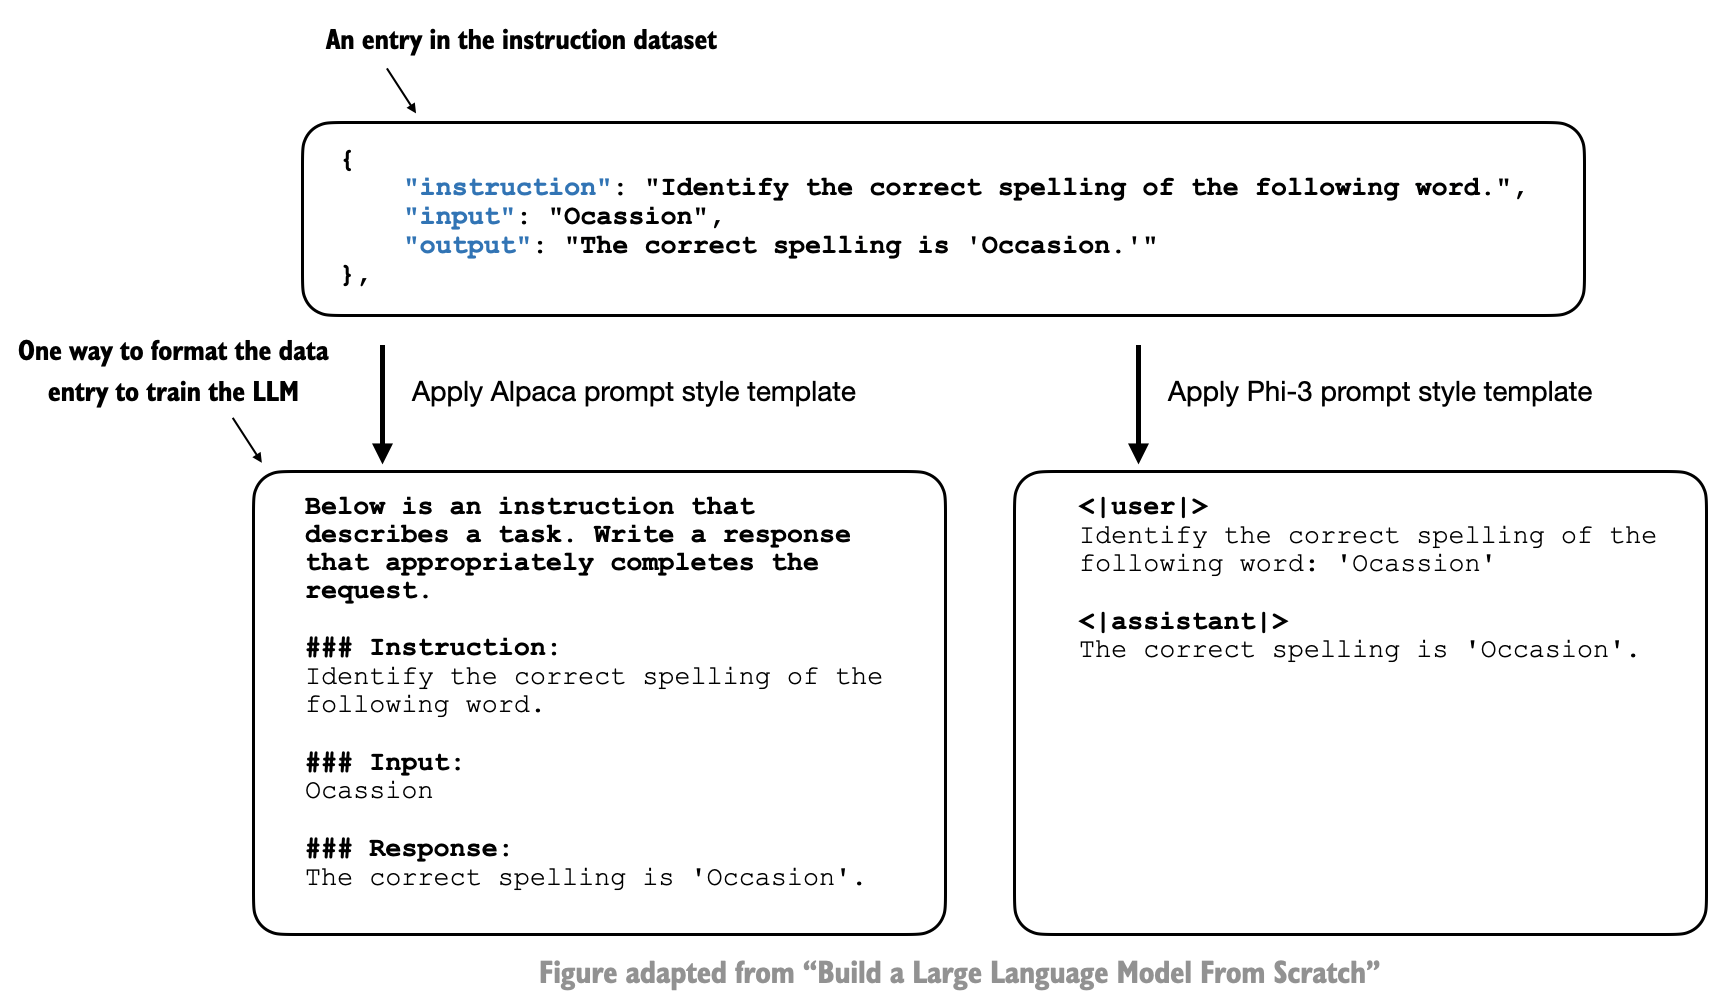

- Suppose we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Shown below is how we format the input that we would pass as input to the LLM

In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- A formatted response with input field looks like as shown below


In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

- Below is a formatted response without an input field


In [ ]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

- Tokenized, this looks like as follows
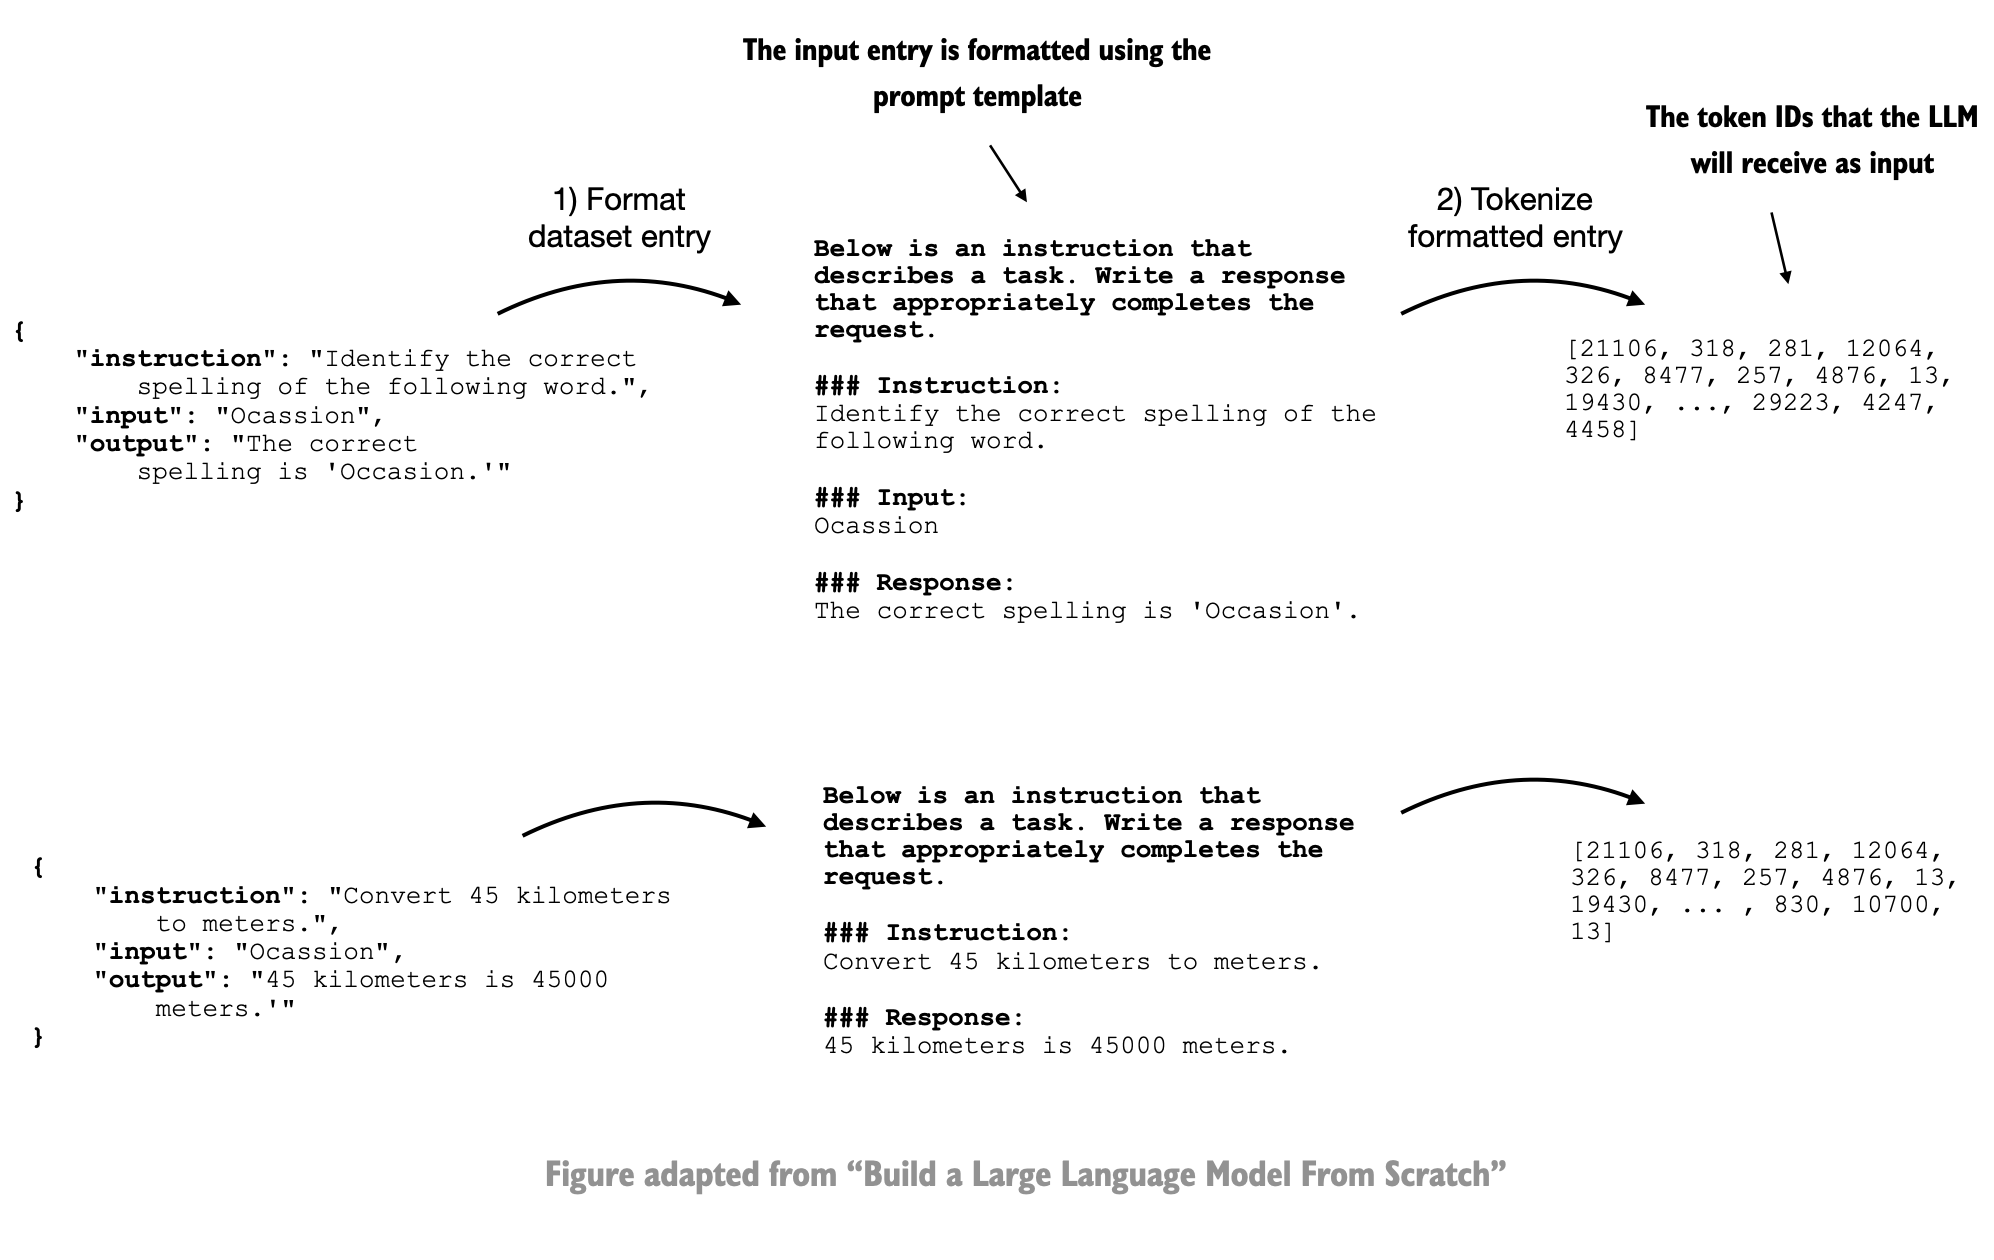

- To make it work with batches, we add "padding" tokens


- In addition, it is also common to mask the target text
- By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100
- Using this -100 ignore_index, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

# 6) Instruction finetuning (part 2; finetuning)
- In this notebook, we get to the actual finetuning part
- But first, let's briefly introduce a technique, called LoRA, that makes the finetuning more efficient
- It's not required to use LoRA, but it can result in noticeable memory savings while still resulting in good modeling performance

## 6.1 Introduction to LoRA
- **Low-rank adaptation (LoRA)** is a machine learning technique that modifies a pretrained model to better suit a specific, often smaller, dataset by adjusting only a small, low-rank subset of the model's parameters
- This approach is important because it allows for efficient finetuning of large models on task-specific data, significantly reducing the computational cost and time required for finetuning

we are essentially approximating the weight updates

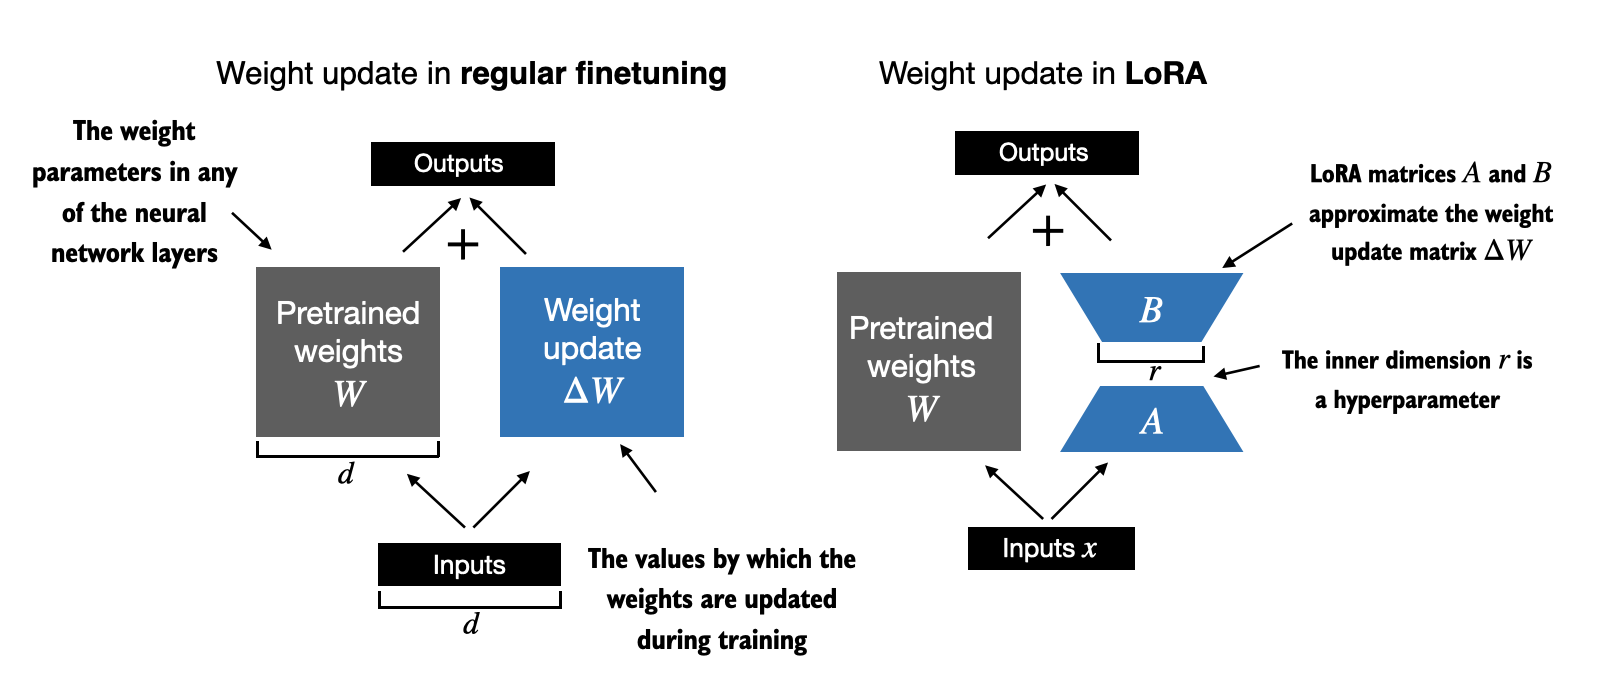

## 6.2 Creating training and test sets
- There's one more thing before we can start finetuning: creating the training and test subsets
- We will use 85% of the data for training and the remaining 15% for testing

In [ ]:
import json


file_path = "LLM-workshop-2024/06_finetuning/instruction-data.json"

with open(file_path, "r") as file:
    data = json.load(file)
print("Number of entries:", len(data))

In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.15)    # 15% for testing

train_data = data[:train_portion]
test_data = data[train_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Test set length:", len(test_data))

In [ ]:
with open("train.json", "w") as json_file:
    json.dump(train_data, json_file, indent=4)
    
with open("test.json", "w") as json_file:
    json.dump(test_data, json_file, indent=4)

## 6.3 Instruction finetuning
Using LitGPT, we can finetune the model via `litgpt finetune model_dir`
However, here, we will use LoRA finetuning `litgpt finetune_lora model_dir` since it will be quicker and less resource intensive

In [ ]:
!litgpt finetune_lora microsoft/phi-2 \
--data JSON \
--data.val_split_fraction 0.1 \
--data.json_path train.json \
--train.epochs 3 \
--train.log_interval 100

## Exercise 1: Generate and save the test set model responses of the base model
- In this excercise, we are collecting the model responses on the test dataset so that we can evaluate them later
- Starting with the original model before finetuning, load the model using the LitGPT Python API (`LLM.load` ...)
- Then use the `LLM.generate` function to generate the responses for the test data
- The following utility function will help you to format the test set entries as input text for the LLM

In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

print(format_input(test_data[0]))

In [ ]:
from litgpt import LLM

llm = LLM.load("microsoft/phi-2")

- iterate over all the test_data points
- format the input, give it to the LLM, generate the response
- assign response to base_model

In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(test_data))):
    response = llm.generate(test_data[i])
    test_data[i]["base_model"] = response

# 6) Instruction finetuning (part 3; benchmark evaluation)
In the previous notebook, we finetuned the LLM; in this notebook, we evaluate it using popular benchmark methods
- There are 3 main types of model evaluation
1. MMLU-style Q&A
2. LLM-based automatic scoring
3. Human ratings by relative preference

MMLU = Measuring Massive Multitask Language Understanding (2020), https://arxiv.org/abs/2009.03300
- essentially measures the known of LLMs based on multiple choice questions

AlpaceEval - https://tatsu-lab.github.io/alpaca_eval/
- leaderboard 

LMSYS chatbot arena leaderboard - https://lmarena.ai/
- crowdsourcing the evaluation
- compare & rank the responses given from different model

# 6) Instruction finetuning (part 4; evaluating instruction responses locally using a Llama 3 model)
- automated way of evaluating an LLM using another LLM


In [17]:
from importlib.metadata import version

pkgs = ["tqdm",    # Progress bar
        ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

tqdm version: 4.66.4


## 6.1 Load JSON Entries
- Now, let's get to the data evaluation part
- Here, we assume that we saved the test dataset and the model responses as a JSON file that we can load as follows:

In [19]:
import json

json_file = "test_response_before_after.json"

with open(json_file, "r") as file:
    json_data = json.load(file)

print("Number of entries:", len(json_data))

one of the entries:

In [ ]:
json_data[0]

- Below is a small utility function that formats the input for visualization purposes later:


In [21]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. Write a response that "
        f"appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    instruction_text + input_text

    return instruction_text + input_text

print(format_input(json_data[0])) # input

In [ ]:
json_data[0]["output"]

In [ ]:
json_data[0]["response_before"]

Now, let's try LitGPT to compare the model responses (we only evaluate the first 5 responses for a visual comparison):

In [ ]:
from litgpt import LLM

llm = LLM.load("meta-llama/Meta-Llama-3-8B-Instruct")

In [ ]:
from tqdm import tqdm


def generate_model_scores(json_data, json_key):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = llm.generate(prompt, max_new_tokens=50)
        try:
            scores.append(int(score))
        except ValueError:
            continue

    return scores